In [3]:
! pip install -U kaggle fastkaggle fastcore fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 kB 33.5 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105124 sha256=e014e16e4a40506c2a11efbcf3dbda5d787ac7804b1b20a849dd1b847313d4a3
  Stored in directory: /root/.cache/pip/wheels/ec/d9/04/93be57edf3835182a8e76d8ff87f7e77a0113f473ba3721ee0
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2020.6.20
    Uninstalling certifi-2020.6.20:
      Successfully uninstalled certifi-2020.6.20


In [9]:
!mkdir ~/.kaggle

In [10]:
!ls .

paddies.ipynb


In [11]:
!ls ~/.kaggle

In [12]:
!mv kaggle.json ~/.kaggle/kaggle.json

In [13]:
!chmod 600 /root/.kaggle/kaggle.json

In [14]:
from fastkaggle import *

In [15]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.02G/1.02G [00:15<00:00, 68.8MB/s]


In [17]:
path

Path('paddy-disease-classification')

In [18]:
from fastai.vision.all import *

In [19]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


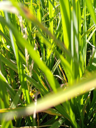

In [20]:
img = PILImage.create(files[10_000])
print(img.size)
img.to_thumb(128)

In [21]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

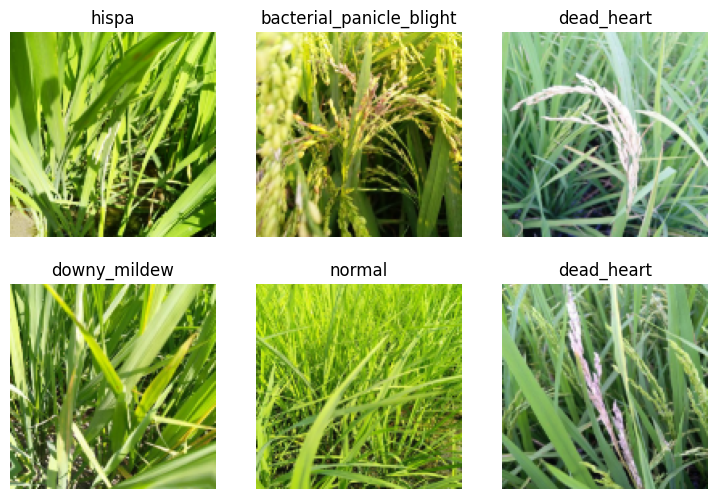

In [23]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [25]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0010000000474974513, slide=0.005248074419796467)

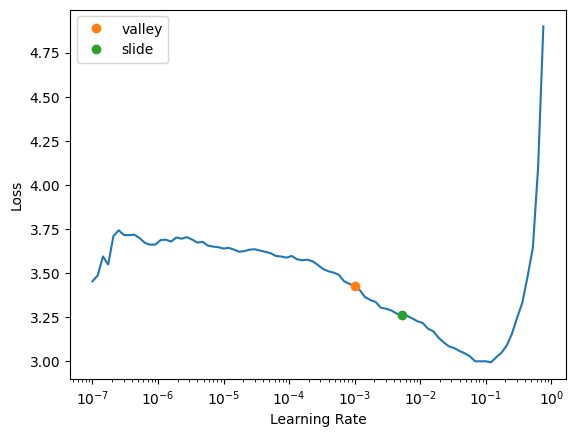

In [26]:
learn.lr_find(suggest_funcs=(valley, slide))

In [27]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.768926,1.209935,0.383950,00:28


epoch,train_loss,valid_loss,error_rate,time
0,1.167482,0.781147,0.262854,00:32
1,0.790257,0.446167,0.150889,00:32
2,0.558025,0.411176,0.132148,00:32


In [28]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [29]:
tst_files = get_image_files(path / 'test_images')
tst_dl = dls.test_dl(tst_files)

In [30]:
probs, _, idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [31]:
idxs

tensor([1, 3, 5,  ..., 8, 7, 8])

In [33]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [38]:
results = pd.Series(dls.vocab[idxs])

In [39]:
ss['label'] = results

In [43]:
ss.to_csv('subm.csv', index=False)

In [44]:
!head subm.csv

image_id,label
200001.jpg,bacterial_leaf_streak
200002.jpg,blast
200003.jpg,dead_heart
200004.jpg,bacterial_leaf_blight
200005.jpg,downy_mildew
200006.jpg,normal
200007.jpg,brown_spot
200008.jpg,tungro
200009.jpg,normal


In [45]:
from kaggle import api
api.competition_submit_cli('subm.csv', 'initial resnet26d 128px', comp)

100%|██████████| 70.0k/70.0k [00:00<00:00, 193kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification

In [46]:
push_notebook()

TypeError: push_notebook() missing 4 required positional arguments: 'user', 'id', 'title', and 'file'